# Setup
(no sé si hace falta con Jupyter pero lo dejo por las dudas, entiendo que sí)

This project uses Python version `3.8`.

From the project root directory, on a [virtual Python environment](https://virtualenvwrapper.readthedocs.io/en/latest/) (or not, if you're feeling brave), run:
```bash
pip3 install -r requirements.txt
```

Make sure that the source directory is added to your `$PYTHONPATH` environment variable.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Dataset
Dediqué bastante tiempo a buscar un dataset. Recuerdo que dijiste que "a partir de 50 variables es más divertido", pero principalmente encontré tres tipos de datasets:

* Datos listos para usar, con menos de 15 variables ya procesadas.
* Tablas gigantes con un montón de variables, llenas de valores inválidos y sin un target feature claro.
* Datasets de clasificación de imágenes.

Finalmente elegí [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), que si bien solo tiene dos clases, tiene 23 columnas de diversos tipos y requiere bastante preprocesamiento. Son datos meteorológicos de Australia con un target feature `RainTomorrow`, que responde a la pregunta "¿llovió al día siguiente?". Los datos están en `weatherAUS.csv`.

# Preprocesamiento de datos


In [4]:
data_frame = pd.read_csv("weatherAUS.csv")
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

A primera vista vemos que las columnas tienen distintos tipos (`float64` para valores numéricos, `object` para variables categóricas) y que faltan valores. Ignoro por qué el tipo de las categóricas es `object` y no `string`.

## Variables redundantes
`RainToday` se puede deducir a partir de `Rainfall` (vale `"Yes"` si `Rainfall` es mayor a 1), por lo que la elimino.

In [5]:
data_frame.drop(columns="RainToday", inplace=True)

## Datos faltantes
La verdad no tengo idea de meteorología (ni del dataset en específico) y no tengo a quién preguntarle, así que no voy a rellenar datos. Mi criterio fue:
* Si falta `RainTomorrow`, borro la fila.
* Si falta más del 10% de los datos de una columna, elimino la variable.
* Si falta hasta el 10% de los datos de una columna, borro las filas donde no esté (total tengo muchos puntos).


In [6]:
data_frame = data_frame[data_frame["RainTomorrow"].notna()]
data_frame = data_frame.loc[:, data_frame.isnull().mean() < 0.1]
data_frame = data_frame.dropna()

## Variables numéricas

In [7]:
numeric_df = data_frame.select_dtypes("number")
numeric_df.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000,112925.000000
mean,12.664721,23.655670,2.377892,40.786611,15.179163,19.500545,67.404162,50.669055,1017.425847,1015.048962,17.462008,22.127306
std,6.254135,6.982702,8.602968,13.321774,8.344304,8.580097,18.911610,20.768550,7.032654,6.957822,6.355045,6.837380
min,-8.200000,2.600000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,-3.100000,1.700000
25%,8.100000,18.300000,0.000000,31.000000,9.000000,13.000000,56.000000,36.000000,1012.800000,1010.300000,12.700000,16.900000
50%,12.400000,23.100000,0.000000,39.000000,13.000000,19.000000,68.000000,51.000000,1017.400000,1015.000000,17.100000,21.600000
75%,17.200000,28.700000,0.800000,48.000000,20.000000,24.000000,81.000000,65.000000,1022.100000,1019.700000,22.000000,26.900000
max,33.900000,48.100000,367.600000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


### Outliers

<AxesSubplot:>

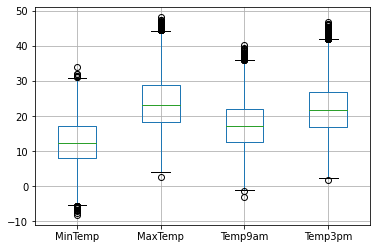

In [8]:
numeric_df.boxplot([col for col in data_frame if "Temp" in col])

<AxesSubplot:>

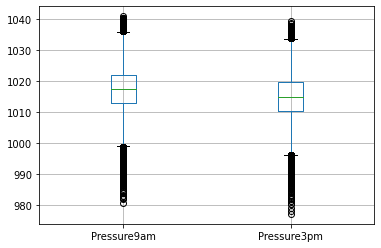

In [9]:
numeric_df.boxplot([col for col in data_frame if "Pressure" in col])

<AxesSubplot:>

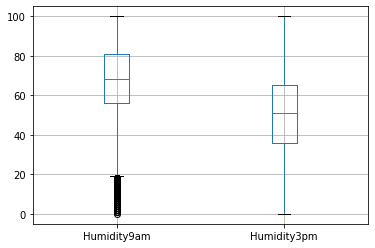

In [10]:
numeric_df.boxplot([col for col in data_frame if "Humidity" in col])

<AxesSubplot:>

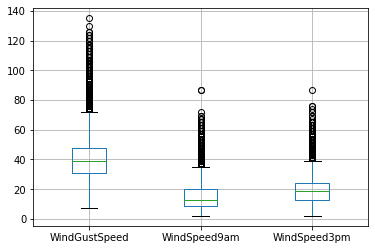

In [11]:
numeric_df.boxplot([col for col in data_frame if "Speed" in col])

<AxesSubplot:>

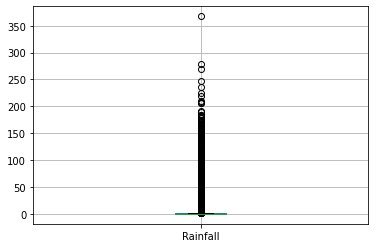

In [12]:
numeric_df.boxplot([col for col in data_frame if "Rainfall" in col])

Apa. A ver qué pasó acá. Viendo la tabla anterior, noto que hay muchos 0 (muchos días que no llueve). De hecho Q3 vale menos que 1, que para este problema es no llover. Eliminar o reemplazar los outliers sería ignorar todos los días que llovió, me parece una pésima idea. Voy a dejar los outliers de `Rainfall` como están.

Vimos que todas las demás variables también tienen outliers (pero más razonables). Como quiero normalizar los datos luego, me voy a deshacer de esos valores. Al no tener conocimientos meteorológicos, me voy a contentar con forzar límites superior e inferior como 2 veces la distancia intercuartil (entre los cuartiles 1 y 3) para cada variable.

In [13]:
# Prevent a false positive warning.
pd.options.mode.chained_assignment = None

for col in numeric_df.drop(columns="Rainfall"):
    Q3 = np.quantile(numeric_df[col], 0.75)
    Q1 = np.quantile(numeric_df[col], 0.25)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    numeric_df[col].clip(lower=lower, upper=upper, inplace=True)

pd.options.mode.chained_assignment = "warn"

### Normalización
Dejamos a cada feature con media 0 y varianza 1.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = pd.DataFrame(
    scaler.fit_transform(numeric_df), columns=numeric_df.columns, index=numeric_df.index
)

## Variables categóricas

In [15]:
data_frame.select_dtypes("object")

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No
1,2008-12-02,Albury,WNW,NNW,WSW,No
2,2008-12-03,Albury,WSW,W,WSW,No
3,2008-12-04,Albury,NE,SE,E,No
4,2008-12-05,Albury,W,ENE,NW,No
...,...,...,...,...,...,...
145454,2017-06-20,Uluru,E,ESE,E,No
145455,2017-06-21,Uluru,E,SE,ENE,No
145456,2017-06-22,Uluru,NNW,SE,N,No
145457,2017-06-23,Uluru,N,SE,WNW,No


### `Date`
Primero pasemos las fechas a `DateTime`. Luego voy a pecar un poco. Me importan dos cosas:
* Preservar distancias entre fechas de calendario (sin importar el año). Porque imagino que si todos los 31 de diciembre son muy calurosos, los 1 de enero también. Para esto uso el trucazo que mostraste para variables cíclicas (con la chanchada de considerar 366 días así no pienso en años bisiestos). Tiene el problema de que el análisis univariado me va a dar cualquier cosa.
* Considerar los años (por si cada año llueve menos, por ejemplo). Para esto simplemente separo el año.

In [16]:
data_frame["Date"] = pd.to_datetime(data_frame["Date"])
data_frame["Year"] = data_frame["Date"].dt.year
norm_date = 2 * np.pi * (data_frame["Date"].dt.dayofyear) / 366
features["SinDate"] = np.sin(norm_date)
features["CosDate"] = np.cos(norm_date)

### Direcciones
Para las direcciones de viento, primero numero cada dirección empezando por N (que es 0) y continuando en sentido horario según:

<img src="compass.pbm" alt="compass" width="400"/>

Y luego, como es cícilico, le aplico la misma transformación que a la fecha.

In [17]:
directions = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
]
dir_dict = dict(
    [(dir, (2 * np.pi * i) / len(directions)) for i, dir in enumerate(directions)]
)
for col in ["WindGustDir", "WindDir9am", "WindDir3pm"]:
    norm_wind = data_frame[col].replace(dir_dict)
    features[f"Sin{col}"] = np.sin(norm_wind)
    features[f"Cos{col}"] = np.cos(norm_wind)

### `RainTomorrow`
Es binaria, así que la convierto a 0 y 1 para `"No"` y `"Yes"` respectivamente. Al ser la *target variable*, la asigno a un dataframe aparte.

In [18]:
target = data_frame["RainTomorrow"].eq("Yes").mul(1)

### `Location`
Veamos si son a lo sumo 20 (así según tu *rule of thumb* hago one hot encoding tranquilo)...

In [19]:
len(data_frame["Location"].unique())

44

... no. Veamos si puedo deshacerme de alguna etiqueta (por tener pocos valores)...

In [20]:
data_frame["Location"].value_counts()[-10:]

Tuggeranong    2316
Dartmoor       2294
Sydney         2259
Melbourne      2233
Williamtown    2195
Richmond       2048
Launceston     1538
Nhil           1518
Uluru          1446
Katherine       670
Name: Location, dtype: int64

... tampoco. Por ahora descarto esta variable. Sería posible usar regiones en vez de ubicaciones (y después tirar one hot encoding), pero son 44 y no quiero hacer el pasaje a mano. Tampoco sé si se corresponden con diferentes climas:

<img src="australia_regions.jpg" alt="regions" width="400"/>

## Falsos predictores
No veo que sea necesario un análisis con árbol de decisión, pues no veo variables correlacionadas con el target.

## Balanceo de clases

In [21]:
target.value_counts() / len(data_frame)

0    0.778446
1    0.221554
Name: RainTomorrow, dtype: float64

Si bien las clases están desbalanceadas, no lo están en en el orden de magnitud de tus ejemplos donde vale la pena hacer sub- u oversampling.

# Análisis de variables relevantes

## Análisis univariado
Vamos a tirar un filtro con [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) como primer approach a ver qué pasa. Quito las transformaciones de variables categóricas cíclicas pues no tiene sentido analizarlas de a una.

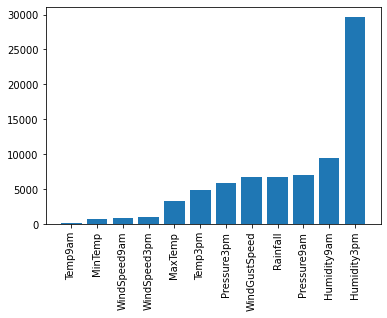

In [22]:
from sklearn.feature_selection import SelectKBest

univ_df = features.drop(
    columns=[col for col in features if col.startswith(("Sin", "Cos"))]
)
selector = SelectKBest(k="all")  # ANOVA by default.
selector.fit(univ_df, target)
univ_scores = sorted(list(zip(selector.scores_, univ_df.columns)))
plt.bar([x[1] for x in univ_scores], [x[0] for x in univ_scores])
plt.xticks(rotation=90)
plt.show()

En base a este gráfico decido descartar las peores 4 variables, es decir, me quedo con las 8 mejores:

In [23]:
selector = SelectKBest(k=8)
selector.fit(univ_df, target)
selected_cols = selector.get_support(indices=True)
filtered_df = univ_df.iloc[:, selected_cols]

Y recupero las columnas de las variables cíclicas.

In [24]:
for col in [col for col in features if col.startswith(("Sin", "Cos"))]:
    filtered_df = filtered_df.join(features[col])
filtered_df.columns

Index(['MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp3pm', 'SinDate', 'CosDate',
       'SinWindGustDir', 'CosWindGustDir', 'SinWindDir9am', 'CosWindDir9am',
       'SinWindDir3pm', 'CosWindDir3pm'],
      dtype='object')

## Análisis multivariado
Vamos a usar [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) con [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) como clasificador para el análisis multivariado. Elegí RF porque es lo que mejor funcionó "out of the box" en los trabajos anteriores. RFECV hace RFE con cross validation para elegir la cantidad de variables a retener, en este caso 5-fold. Con [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) me aseguro que los folds que respeten la proporción de clases.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

estimator = RandomForestClassifier()
min_features = 10
selector = RFECV(estimator, cv=StratifiedKFold(5), step = 1, min_features_to_select=min_features)


selector.fit(filtered_df, target)
print(f"Optimal number of features : {selector.n_features_}")

Optimal number of features : 16


Bueno, parece que hay que usar todas las variables. Dejo los datos como están.

# Clustering

## PCA
Vamos a hacer un PCA (los datos ya están escalados) para ver si encontramos clusters.

In [26]:
from sklearn.decomposition import PCA

pca = PCA().fit_transform(filtered_df)
pca_data_frame = pd.DataFrame(
    data=pca,
    columns=[f"pc_{idx}" for idx in range(1, pca.shape[1] + 1)],
    index=filtered_df.index,
)

Graficamos las primeras dos componentes del PCA:

In [27]:
import matplotlib.colors as mcolors


def graph_clusters(data_frame, klass_list, x_label, y_label, target_label):
    color_list = list(mcolors.TABLEAU_COLORS.keys())
    for klass, color in zip(klass_list, color_list):
        idx_list = data_frame[target_label] == klass
        plt.scatter(
            data_frame.loc[idx_list, x_label],
            data_frame.loc[idx_list, y_label],
            marker=".",
            color=color,
        )
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(klass_list)
    plt.show()

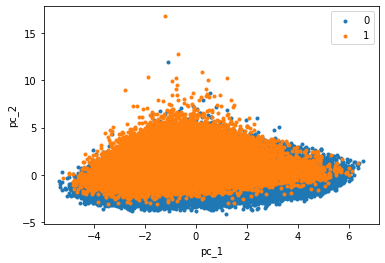

In [28]:
pca_target_df = pca_data_frame.join(target)
klass_list = pca_target_df["RainTomorrow"].unique()
x_label = "pc_1"
y_label = "pc_2"

graph_clusters(pca_target_df, klass_list, x_label, y_label, "RainTomorrow")

No se entiende nada. Pero ya que estamos en el baile, bailemos.

## Búsqueda de clusters
A ojímetro por el gráfico anterior, le tengo más fe a [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html?highlight=agglomerative#sklearn.cluster.AgglomerativeClustering) que a K-Means... aunque no le tengo fe a ninguno. Pero me dio Memory Error. Así que vamos con [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans).

K-Means score: 0.7784458711534205


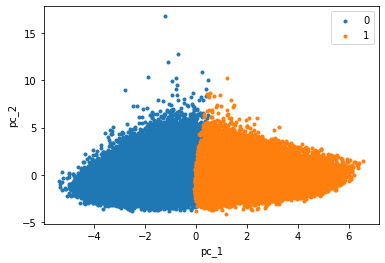

In [29]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans

# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    cont_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)


n_clusters = 2
method = KMeans(n_clusters=n_clusters)
prediction = method.fit_predict(pca_data_frame)
print(f"K-Means score: {purity_score(target, prediction)}")

pca_target_df["prediction"] = prediction
graph_clusters(pca_target_df, klass_list, x_label, y_label, "prediction")

Da sorprendentemente bien (a pesar de que gráficamente parece cualquier cosa). Wow. Esperaba un score cercano a `0.5`. Quizás `pc_1` y `pc_2` no son representativos de todas las dimensiones (ya que hay 16 dimensiones).

## Cantidad de clusters
Vamos a usar Gap Statistic para ver si la cantidad "ideal" de clusters es 2. Esto es un copypaste levemente modificado del TP de clustering (en realidad gran parte de este informe es copypaste de TPs anteriores). Pruebo cantidades de clusters en el rango `[1, 10]` y genero 20 distribuciones uniformes en el PCA de los datos para cada cantidad de clusters:

cluster size: 1


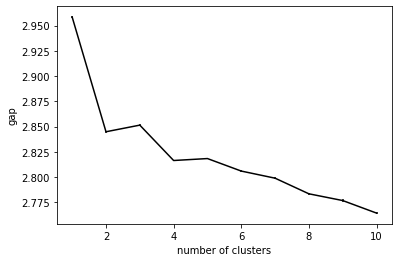

In [36]:
max_clusters = 10
uniform_count = 20
method = KMeans

# Generates a uniform distribution with the same amount of
# data points in the hyperrectangle of the source data frame.
def generate_uniform(source_data):
    uniform_data = source_data.copy().transpose()
    # Iterate over the columns (features) of the original matrix.
    for idx, row in enumerate(uniform_data):
        uniform_data[idx] = np.random.uniform(row.min(), row.max(), len(row))
    return uniform_data.transpose()


# Calculate log inertia for different cluster amounts.
data_inertia = [
    np.log(method(n_clusters=n_clusters).fit(pca_data_frame).inertia_)
    for n_clusters in range(1, max_clusters + 1)
]

# Apply PCA.
pca = PCA().fit_transform(pca_data_frame)

# Calculate log inertia for uniform distributions.
uniform_inertia = np.zeros((max_clusters, uniform_count))
for cluster_idx in range(max_clusters):
    for iteration in range(uniform_count):
        uniform_data_frame = generate_uniform(pca)
        uniform_inertia[cluster_idx][iteration] = np.log(
            method(n_clusters=cluster_idx + 1).fit(uniform_data_frame).inertia_
        )

# Calculate mean and gap statistic.
uniform_inertia_mean = np.mean(uniform_inertia, axis=1)
gap = uniform_inertia_mean - data_inertia

# Calculate standard deviation and adjusted standard deviation.
uniform_inertia_sd = np.zeros(max_clusters)
for cluster_idx in range(max_clusters):
    uniform_inertia_sd[cluster_idx] = np.sqrt(
        np.mean(
            np.square(uniform_inertia[cluster_idx] - uniform_inertia_mean[cluster_idx])
        )
    )
uniform_inertia_s = uniform_inertia_sd * np.sqrt(1 + 1 / uniform_count)

# Graph gap statistic.
plt.errorbar(np.arange(max_clusters) + 1, gap, uniform_inertia_s, color="k")
plt.xlabel("number of clusters")
plt.ylabel("gap")

# Use gap statistic to select cluster size.
cluster_size = max_clusters
for k in range(1, max_clusters):
    if gap[k - 1] >= gap[k] - uniform_inertia_s[k]:
        # This is because gap[k] is the gap statistic for k+1 clusters.
        cluster_size = k
        break
print(f"cluster size: {cluster_size}")
plt.show()

Dice claramente que no hay clusters, cosa que me creo por la forma horrible de las gráficas anteriores.

# Clasificación

## Metodología
Vamos con el viejo y querido método de hacer CV para estimar el error (y recursivamente CV para encontrar parámetros óptimos):
1. Separo 1/5 de los datos como conjunto de validación, el resto como training usando [`StratifiedKFold` de scikit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) para mantener las proporciones de las clases en los folds.
2. Sobre los datos de training vuelvo a hacer 5-fold cross validation para elegir parámetros óptimos utilizando [`GridSearchCV` de scikit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).
3. Entreno el modelo usando todos los datos de training (usando los parámetros óptimos) y obtengo su error de clasificación sobre el conjunto de validación.
4. Repito los pasos 1 a 3 para cada fold y promedio los errores de clasificación. El promedio es mi error estimado de test.

In [33]:
from sklearn.model_selection import GridSearchCV

def err_estimator(features, target, estimator, n_splits, param_grid):
    estimated_err = 0
    k_fold = StratifiedKFold(n_splits, shuffle=True)
    for train_index, val_index in k_fold.split(features, target):
        random_forest = GridSearchCV(estimator, param_grid)
        random_forest.fit(features.iloc[train_index], target.iloc[train_index])
        val_score = random_forest.score(features.iloc[val_index], target.iloc[val_index])
        estimated_err += 1 - val_score
        print(
            f"Validation error: {1 - val_score} with params: {random_forest.best_params_}"
        )
    estimated_err /= k_fold.get_n_splits()
    
    print(f"Estimated test error: {estimated_err}")

## Random Forest
Copy paste del TP anterior: "el número de árboles no es importante, mientras sean muchos", por lo que el único parámetro a ajustar es la cantidad de features que se evalúan por nodo. Usé 1000 árboles y busqué el óptimo a ojímetro cerca de la raíz cuadrada de la cantidad de features totales (la raíz es 4).

In [35]:
estimator = RandomForestClassifier(n_estimators=1000)
n_splits = 2
param_grid = {"max_features": [4]}#[2, 3, 4, 6, 8]}

err_estimator(filtered_df, target, estimator, n_splits, param_grid)

KeyboardInterrupt: 

## SVM Polinomial
 Me quiero sacar las ganas de que SVM ande bien. Esta vez los datos ya los escalé previamente. Usando la implementación [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) con `kernel="poly"`, voy a ajustar `C` y `degree`, el grado del polinomio.

In [ ]:
from sklearn.svm import SVC

estimator = SVC(kernel="poly")
n_splits = 5
param_grid = {"degree": list(range(1, 7)), "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

err_estimator(filtered_df, target, estimator, n_splits, param_grid)

## SVM RBF
 Y seguimos con SVM. De nuevo, uso [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC), aunque esta vez con `kernel="rbf"`. Voy a ajustar `C` y `gamma`.

In [ ]:
file_stem = "lampone"
estimator = SVC(kernel="rbf")
n_splits = 5
param_grid = {
    "gamma": np.logspace(-10, 10, 21),
    "C": np.logspace(-10, 10, 21),
}

## Conclusiones